# MNIST training example

This notebook presents a full commented implementation of the jacobian optimization method introduced in [1][Relative gradient optimization of the Jacobian term in unsupervised deep learning](https://arxiv.org/pdf/2006.15090.pdf)

## Imports

The method has been implemented using Python and [JAX](https://github.com/google/jax).

In [1]:
import jax.numpy as jnp
import time

from jax                 import random, vmap, jit, grad
from jax.nn.initializers import orthogonal
from jax.scipy.stats     import norm
from jax.experimental    import optimizers as opt

from experiments.utils   import shuffle_perm, batchify
from itertools           import chain

## Hyperparameters

In [3]:
n_layers   = 2
seed       = 42
n_epochs   = 10
lr         = 1e-4
batch_size = 10

# JAX random generator key
key = random.PRNGKey(seed)

## Loading the training dataset

We load the MNIST training and validation datasets as simple matrices of size NxD where N will usually be the `batch_size` and D = 784 (MNIST flattened dimensionality). As the first dimension is the batch dimension, we assume the samples to be arranged by rows.

In [4]:
import sys
sys.path.append('experiments/')
from datasets.dataloaders import load_dataset
x, val_data, _, _ = load_dataset("MNIST")

## Model definition

We implement the `smooth_leaky_relu` activation function
$s_L(x) = \alpha x + (1 - \alpha) \log (1 + e^x)$ and the `Dense` fully-connected layer we use. The `dummy` argument to the `Dense` layer represents the `Accumulator` layer described in Appendix D of [[1]](https://arxiv.org/pdf/2006.15090.pdf).

In [5]:
def smooth_leaky_relu(x, alpha=0.01):
    """Smoothed version of the leaky relu activation function
    Inspiration:
    https://stats.stackexchange.com/questions/329776/approximating-leaky-relu-with-a-differentiable-function
    """
    return alpha*x + (1 - alpha)*(jnp.logaddexp(x, 0))

nonlinearity = smooth_leaky_relu

def Dense(params, x, dummy=0):
    W, b = params
    return jnp.dot(x, W) + dummy + b

Below we define the functions to initialize the parameters and build the model. In the end, the model will be specified by its `params` and 3 `g` functions; all the 3 functions perform a forward pass through the model, but with some differences:

* `g_dummy` takes 3 arguments: `params`, `x`, `dummy`. The `dummy` argument is needed to be able to accumulate the $\delta$ gradients when needed (Appendix D of [[1]](https://arxiv.org/pdf/2006.15090.pdf)).
* `g_layerwise` returns the output `z` (the latent variables) and the activations `ys` for each layer (no non-linearities applied).
* `g`: returns `z` only

In [6]:
def get_dummy_params(params, x):
    return [jnp.zeros(x.shape) for p in params]

def get_model(n_features, n_layers,
              nonlinearity=smooth_leaky_relu,
              key=random.PRNGKey(0),
              W_init=orthogonal()):

    # Forward pass through the network.
    # Returns the latent configurations `z`
    # and the activations at intermediate layers `ys`.
    def forward(params, dummies, x):

        z = x

        def step(Wb, dummy):
            nonlocal z
            y = Dense(Wb, z, dummy=dummy)
            z = nonlinearity(y)
            return y

        ys = [step(Wb, dummy) for (Wb, dummy) in zip(params[:-1], dummies[:-1])]

        # last layer (no nonlinearity)
        z = Dense(params[-1], z, dummies[-1])

        return z, ys

    g_dummy = forward

    def g_layerwise(params, x):
        dummies = get_dummy_params(params, x)
        return g_dummy(params, dummies, x)

    g = lambda params, x: g_layerwise(params, x)[0]

    # parameters init
    def init_Wb(key, n_features):
        return W_init(key, (n_features, n_features)), jnp.zeros((1, n_features))

    params = [init_Wb(k, n_features) for k in random.split(key, n_layers)]

    return params, g_dummy, g_layerwise, g

params, g_dummy, g_layerwise, g = get_model(x.shape[-1], n_layers,
                                    nonlinearity=smooth_leaky_relu,
                                    key=key)

## Loss function

The objective function to optimize is the loglikelihood of our model $\boldsymbol{L}(\boldsymbol{x}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{x})$ that we rewrite as $\boldsymbol{L}(\boldsymbol{x}) = \boldsymbol{L}_p(\boldsymbol{x}) + \boldsymbol{L}_J(\boldsymbol{x})$ with

$$
\boldsymbol{L}_p (\boldsymbol{x}) = \sum_i \log p_i(\boldsymbol{g}^i_{\boldsymbol{\theta}}(\boldsymbol{x})) ; \enspace \ \boldsymbol{L}_J (\boldsymbol{x}) = \log \left|\det \boldsymbol{J}\boldsymbol{g}_{\boldsymbol{\theta}}(\boldsymbol{x})\right|\,, 
$$

We further separate $\boldsymbol{L}_J$ in a "layerwise" component $\boldsymbol{L}_J^1$ depending on the intermediate layers activations $\boldsymbol{y}_k$ and a component $\boldsymbol{L}_J^2$ depending on the parameters only

$$
\begin{align}
 \boldsymbol{L}_J (\boldsymbol{z}_{k-1}) &= \sum_{i=1}^D\log \left| \sigma'(y_{k}^{i}) \right| + \log \left| \det \boldsymbol{W}_k \right| \\
    &=: \boldsymbol{L}_J^{1}(\boldsymbol{y}_{k}) + \boldsymbol{L}_J^{2}(\boldsymbol{z}_{k-1})\,.
\end{align}
$$

The gradient of the $\boldsymbol{L}_J^2$ term is calculated explicitly and can be computed efficiently by making use of the relative gradient trick (see section 4 of [[1]](https://arxiv.org/pdf/2006.15090.pdf)). Through automatic differentiation we optimize the latent variables distribution of choice $\boldsymbol{L}_p$ (a standard Gaussian in this case) and the `loss_layerwise` term $\boldsymbol{L}_J^1$.

In [7]:
@jit
@vmap
def log_pdf_normal(s):
    """ Log-pdf for a Gaussian distribution w. mean 0 std 1"""
    return jnp.sum(norm.logpdf(s))

def inner_layerwise(sigma_prime, y):
    return jnp.log(vmap(vmap(sigma_prime))(y))

def loss_layerwise(nonlinearity, ys):
    sigma_prime = grad(nonlinearity)
    batched = vmap(inner_layerwise, in_axes=(None, 0))

    # summing individual layers contributions
    # Note: this works fine even with `len(ys)` == 2
    full_pass = jnp.sum(batched(sigma_prime, jnp.stack(ys)), axis=0)

    # summing over dimension
    return jnp.sum(full_pass, axis=1)

# Here the `dummies` argument is needed to be able to compute the `delta` terms (Appendix D in [1])
# through the JAX `grad` function.
def loss(params, dummies, x):

    z, ys = g_dummy(params, dummies, x)

    lpdf = log_pdf_normal(z)
    lwise = loss_layerwise(nonlinearity, ys)

    l = - sum(jnp.mean(li) for li in [lpdf, lwise])

    return l, (z, ys)

## Relative gradient

Here we compute the gradient and apply the relative trick taking care of avoiding matrix-matrix multiplications as described in Section 4 of [[1]](https://arxiv.org/pdf/2006.15090.pdf).

The core of the computation happens in the `apply_trick` function, where the updates are computed following Appendix F of [[1]](https://arxiv.org/pdf/2006.15090.pdf) to include biases (note that we transposed the update expressions as we are working with row vectors).

The `add_det_grad` function completes the gradient updates by including the gradients of the $\boldsymbol{L}_J^2$ term of the loglikelihood, that we compute explicitly.

In [8]:
def get_relative_gradient(gradient):

    def apply_trick(Wb, z, bp_terms):
        W, b = Wb
        db, delta = bp_terms

        dW = W @ (W.T @ z.T) @ delta + W @ b.T @ db
        db = db * (1 + b @ b.T) + b @ W.T @ z.T @ delta

        return (dW, db)

    def relative_gradient(params, x):

        dummies = get_dummy_params(params, x)
        ((grads, deltas), (z, ys)) = gradient(params, dummies, x)

        dbs = (db for (dW, db) in grads)
        bp_terms = zip(dbs, deltas) # backprop terms
        zs = chain([x], (nonlinearity(y) for y in ys))

        return [apply_trick(*args) for args in zip(params, zs, bp_terms)]

    return relative_gradient

def add_det_grad(gradient):

    def det_grad(params, x):
        grad_params = gradient(params, x)
        return [(dW - W, db) for ((dW, db), (W, b)) in zip(grad_params, params)]

    return det_grad

gradient = grad(loss, argnums = (0, 1), has_aux = True)
gradient = add_det_grad(get_relative_gradient(gradient))

## Logging

The `train` function accepts a list of `loggers` to log scalar values. Each logger must be a function taking arguments `params` and `epoch` and must return a tuple: the first element is a string indicating the name of the logged quantity, the second element is the value to log. We define in this way a function `log_loss` to log the loglikelihood on the validation set during training, and a `log_time` function to log the execution time of each epoch.

In [9]:
# Function to compute the term L^2_J of the loglikelihood
def log_abs_det(params):
    Ws = [W for (W, b) in params]
    return jnp.sum(jnp.linalg.slogdet(Ws)[1])

# Note that here we want to log the full loglikelihood;
# during training we directly optimize only the term `l1 + l2`
# and we include the gradient of the term `l3` explicitly
# (i.e. the `loss` function we derive include only `l1 + l2`
# and the `l3` term is introduced with `add_det_grad`)
@jit
def full_loss(params, x):
    z, ys = g_layerwise(params, x)

    l1 = jnp.mean(log_pdf_normal(z))
    l2 = jnp.mean(loss_layerwise(nonlinearity, ys))
    l3 = log_abs_det(params)

    return l1 + l2 + l3

def get_loss_logger():
    
    loss_vs_time = []
    
    def log_loss(params, epoch):
        val_loss = full_loss(params, val_data)
        loss_vs_time.append(val_loss)
        return "Loglikelihood", val_loss
    
    return log_loss, lambda: loss_vs_time

log_loss, get_loss_vs_time = get_loss_logger()

def timer():
    start = time.perf_counter()

    def log_time(params, epoch):
        nonlocal start
        now = time.perf_counter()
        delta = now - start
        start = now
        return "Time", delta

    return log_time

## Training loop with Adam optimizer

Here we define a standard [JAX-experimental](https://github.com/google/jax/tree/master/jax/experimental) training loop using Adam with default parameters. We only add the `loggers` interface.

In [10]:
def get_opt_update(get_params, opt_update, gradients):

    @jit
    def update(i, opt_state, batch):
        params = get_params(opt_state)
        grads = gradients(params, batch)
        return opt_update(i, grads, opt_state)

    return update

def train(params, x, gradients,
          epochs = 100, batch_size = 10, lr = 1e-3, shuffle = True,
          loggers = [], log_every = 10):

    opt_init, opt_update, get_params = opt.adam(lr)
    update = get_opt_update(get_params, opt_update, gradients)
    opt_state = opt_init(params)

    for i in range(1, epochs + 1):
        # TODO: shuffle in-place to reduce memory allocations (first, copy data)
        x, _ = shuffle_perm(x) if shuffle else (x, None)
        batches = batchify(x, batch_size)
        for batch in batches:
            opt_state = update(i, opt_state, batch)

        if i % log_every == 0:
            params = get_params(opt_state)
            logs = [log(params, i) for log in loggers]
            print(f"Epoch {i}", end=" ")
            for log in logs:
                print('[%s %.2f]' % (log), end=" ")
            print()

## Training

See it in action!

In [11]:
train(params, x, gradient,
      epochs     = n_epochs,
      lr         = lr, 
      batch_size = batch_size,
      loggers    = [log_loss, timer()],
      log_every  = 1
     )

Epoch 1 [Loglikelihood -1432.02] [Time 42.70] 
Epoch 2 [Loglikelihood -1393.83] [Time 40.14] 
Epoch 3 [Loglikelihood -1383.73] [Time 40.05] 
Epoch 4 [Loglikelihood -1379.98] [Time 40.33] 
Epoch 5 [Loglikelihood -1378.05] [Time 40.41] 
Epoch 6 [Loglikelihood -1377.01] [Time 40.33] 
Epoch 7 [Loglikelihood -1376.31] [Time 40.68] 
Epoch 8 [Loglikelihood -1375.77] [Time 40.67] 
Epoch 9 [Loglikelihood -1375.43] [Time 40.40] 
Epoch 10 [Loglikelihood -1375.32] [Time 40.58] 


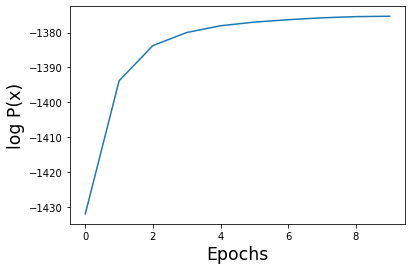

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel('log P(x)', fontsize='xx-large')
ax.set_xlabel('Epochs', fontsize='xx-large')
plt.plot(get_loss_vs_time())
plt.show()